# Bilateral Denoising

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [2]:
%cd /tf/notebooks

/tf/notebooks


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from skimage.restoration import denoise_bilateral


import cv2
from deepface import DeepFace


In [5]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path).resize(shape)
        img = np.array(img)
        img = preprocessing(img)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [6]:
def bilateral_denoising(img):  
    #img = Image.open(img)
    return cv2.bilateralFilter(img, 15, 75, 75)

## Example

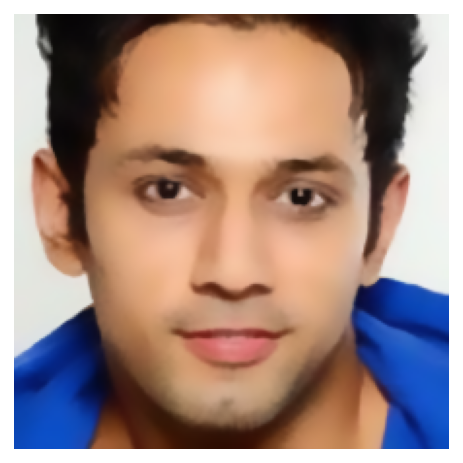

In [7]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
plt.imshow(indian_img)
plt.axis('off');

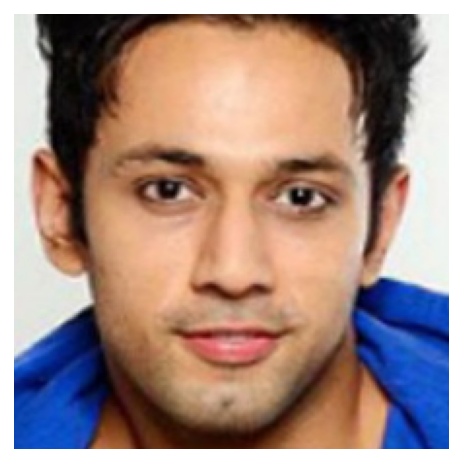

In [8]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img)
plt.axis('off');

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [8]:
facenet_model = "facenet_bilateral_denoising"

In [9]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.927621,0.926609,0.928633
0,African,0.906664,0.905495,0.907834
0,Asian,0.903961,0.902907,0.905014
0,Caucasian,0.883436,0.882153,0.884719


In [10]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.839297,0.837934,0.840660
0,Asian,0.830083,0.828771,0.831395
0,African,0.830037,0.828578,0.831495
0,Caucasian,0.755753,0.754264,0.757243


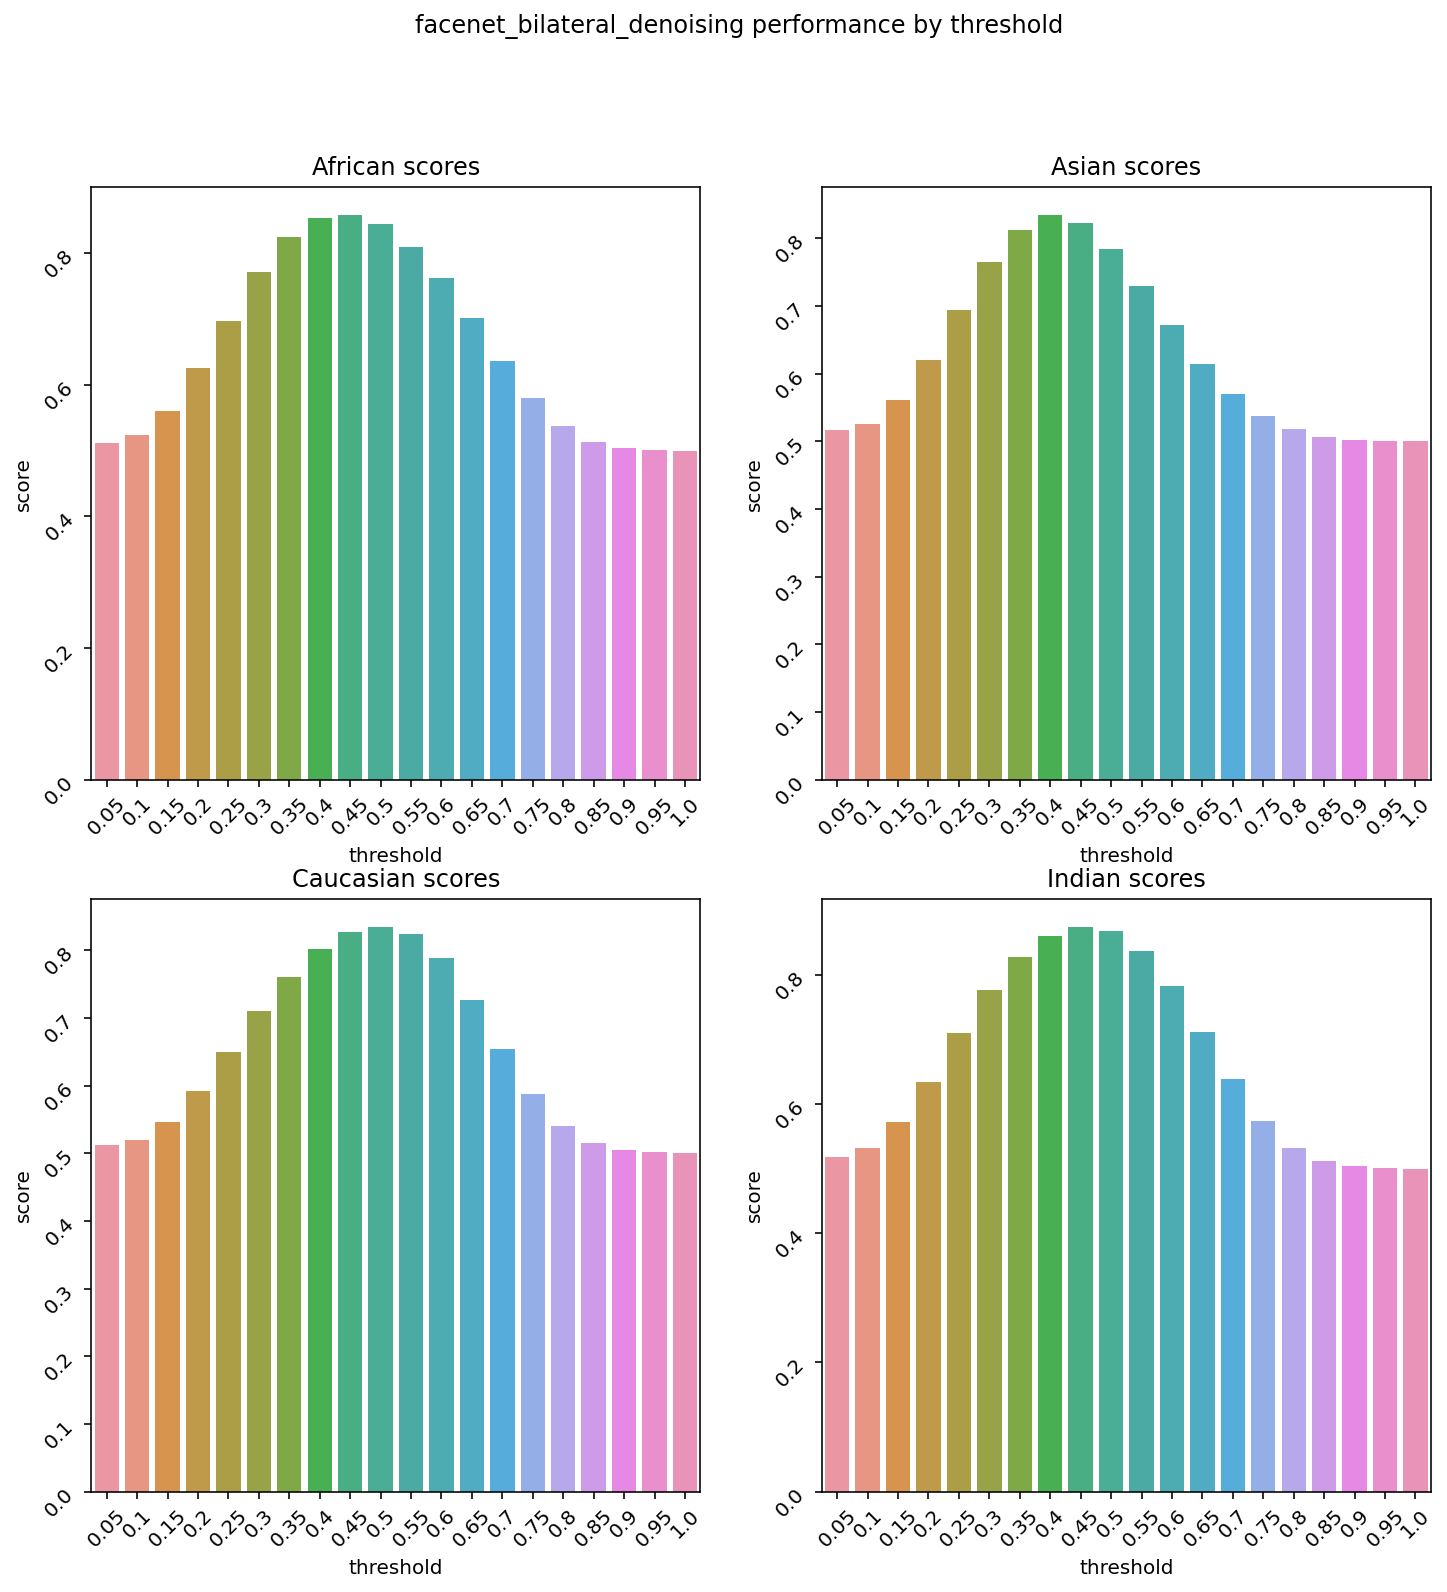

In [11]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [12]:
vgg_face_model = "vgg_face_bilateral_denoising"


In [13]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.888300,0.887111,0.889488
0,Asian,0.840737,0.839342,0.842133
0,African,0.834004,0.832411,0.835598
0,Caucasian,0.814661,0.813072,0.816251


In [19]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.756180,0.754667,0.757693
0,Caucasian,0.747500,0.745922,0.749078
0,African,0.696517,0.694815,0.698218
0,Asian,0.639267,0.637558,0.640975


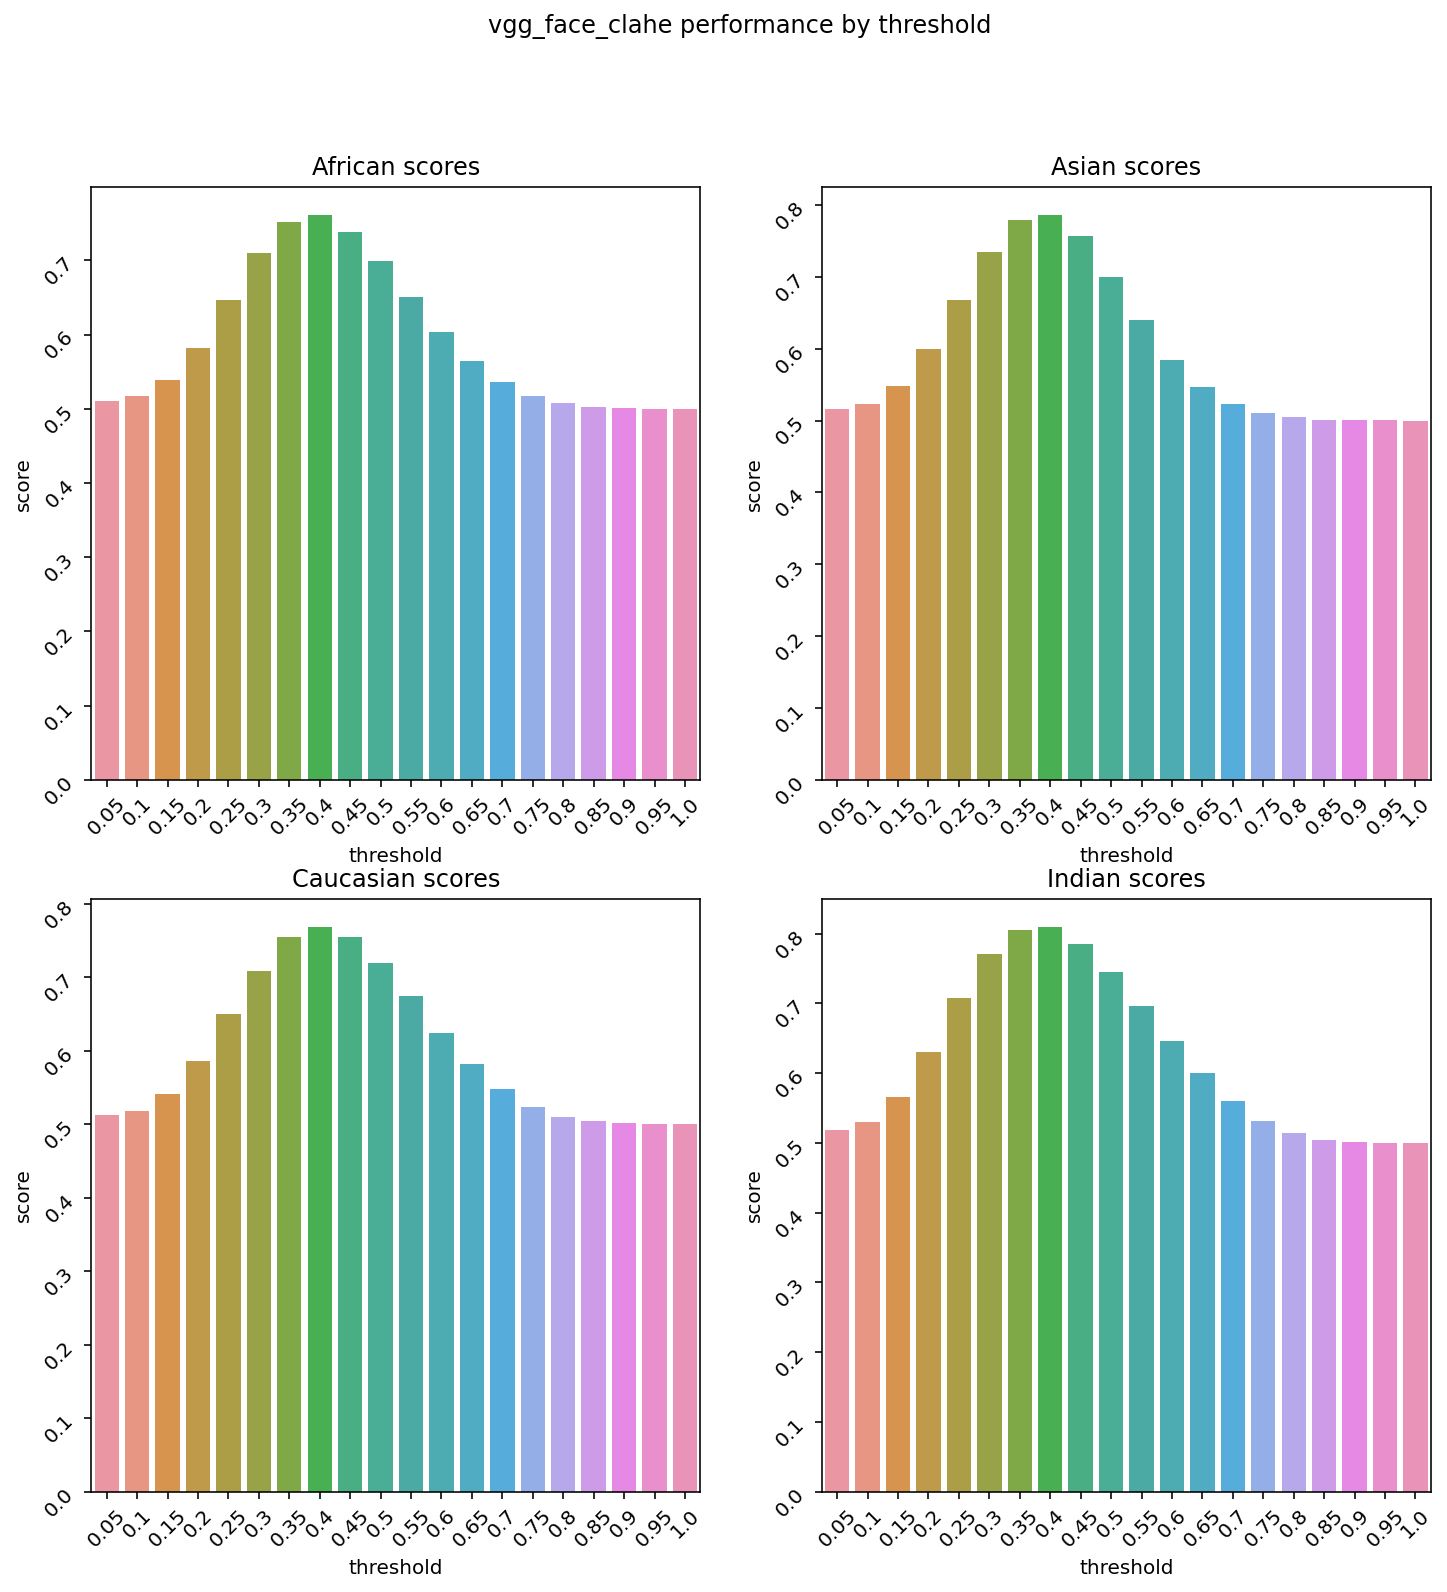

In [12]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [14]:
arcface_model = "arcface_bilateral_denoising"

In [15]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,African,0.807104,0.805452,0.808755
0,Indian,0.803187,0.801578,0.804797
0,Caucasian,0.781660,0.779937,0.783382
0,Asian,0.761971,0.760378,0.763565


In [16]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.655027,0.653318,0.656735
0,African,0.648873,0.647020,0.650727
0,Caucasian,0.646987,0.645293,0.648680
0,Asian,0.630860,0.629294,0.632426


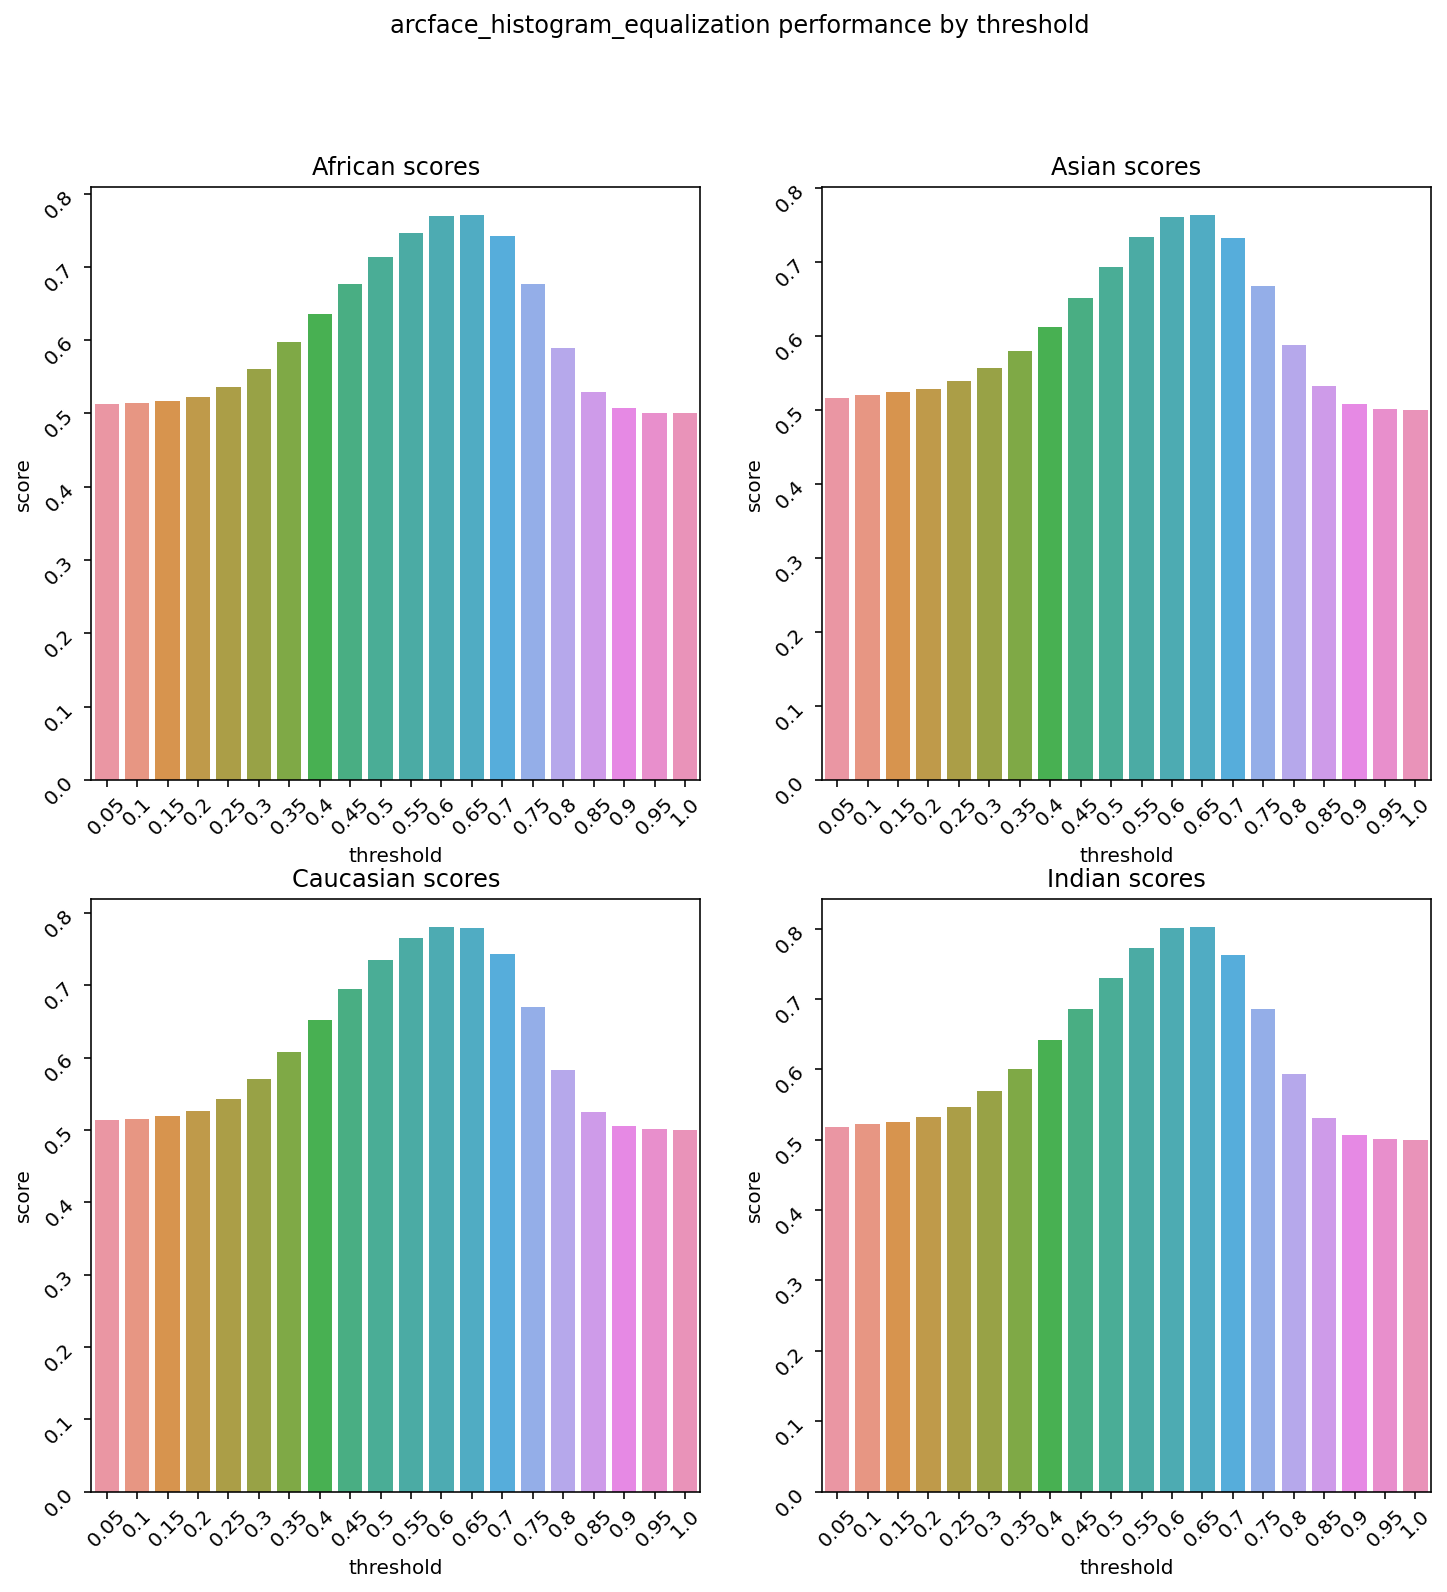

In [16]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

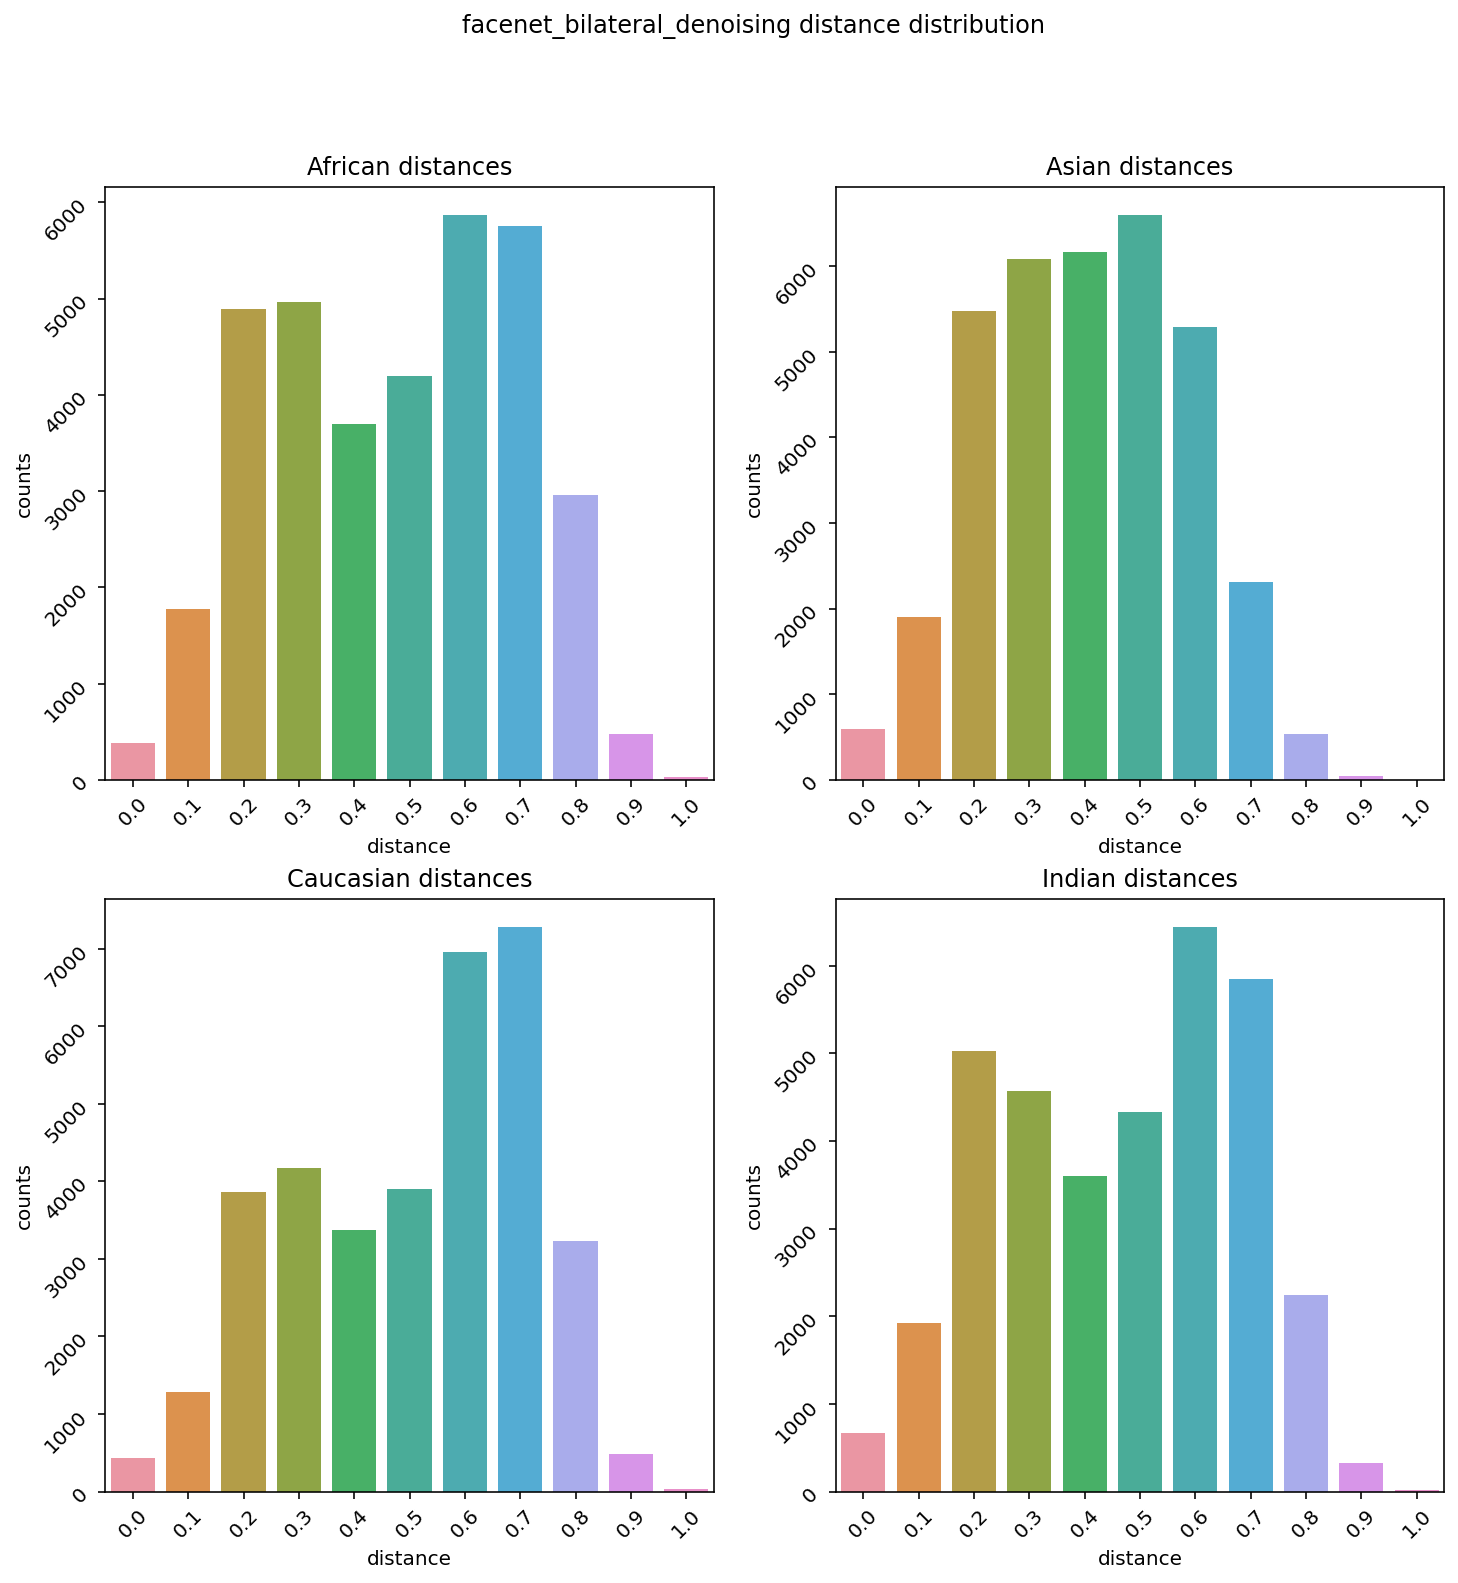

In [17]:
plot_score_distribution(facenet_model)

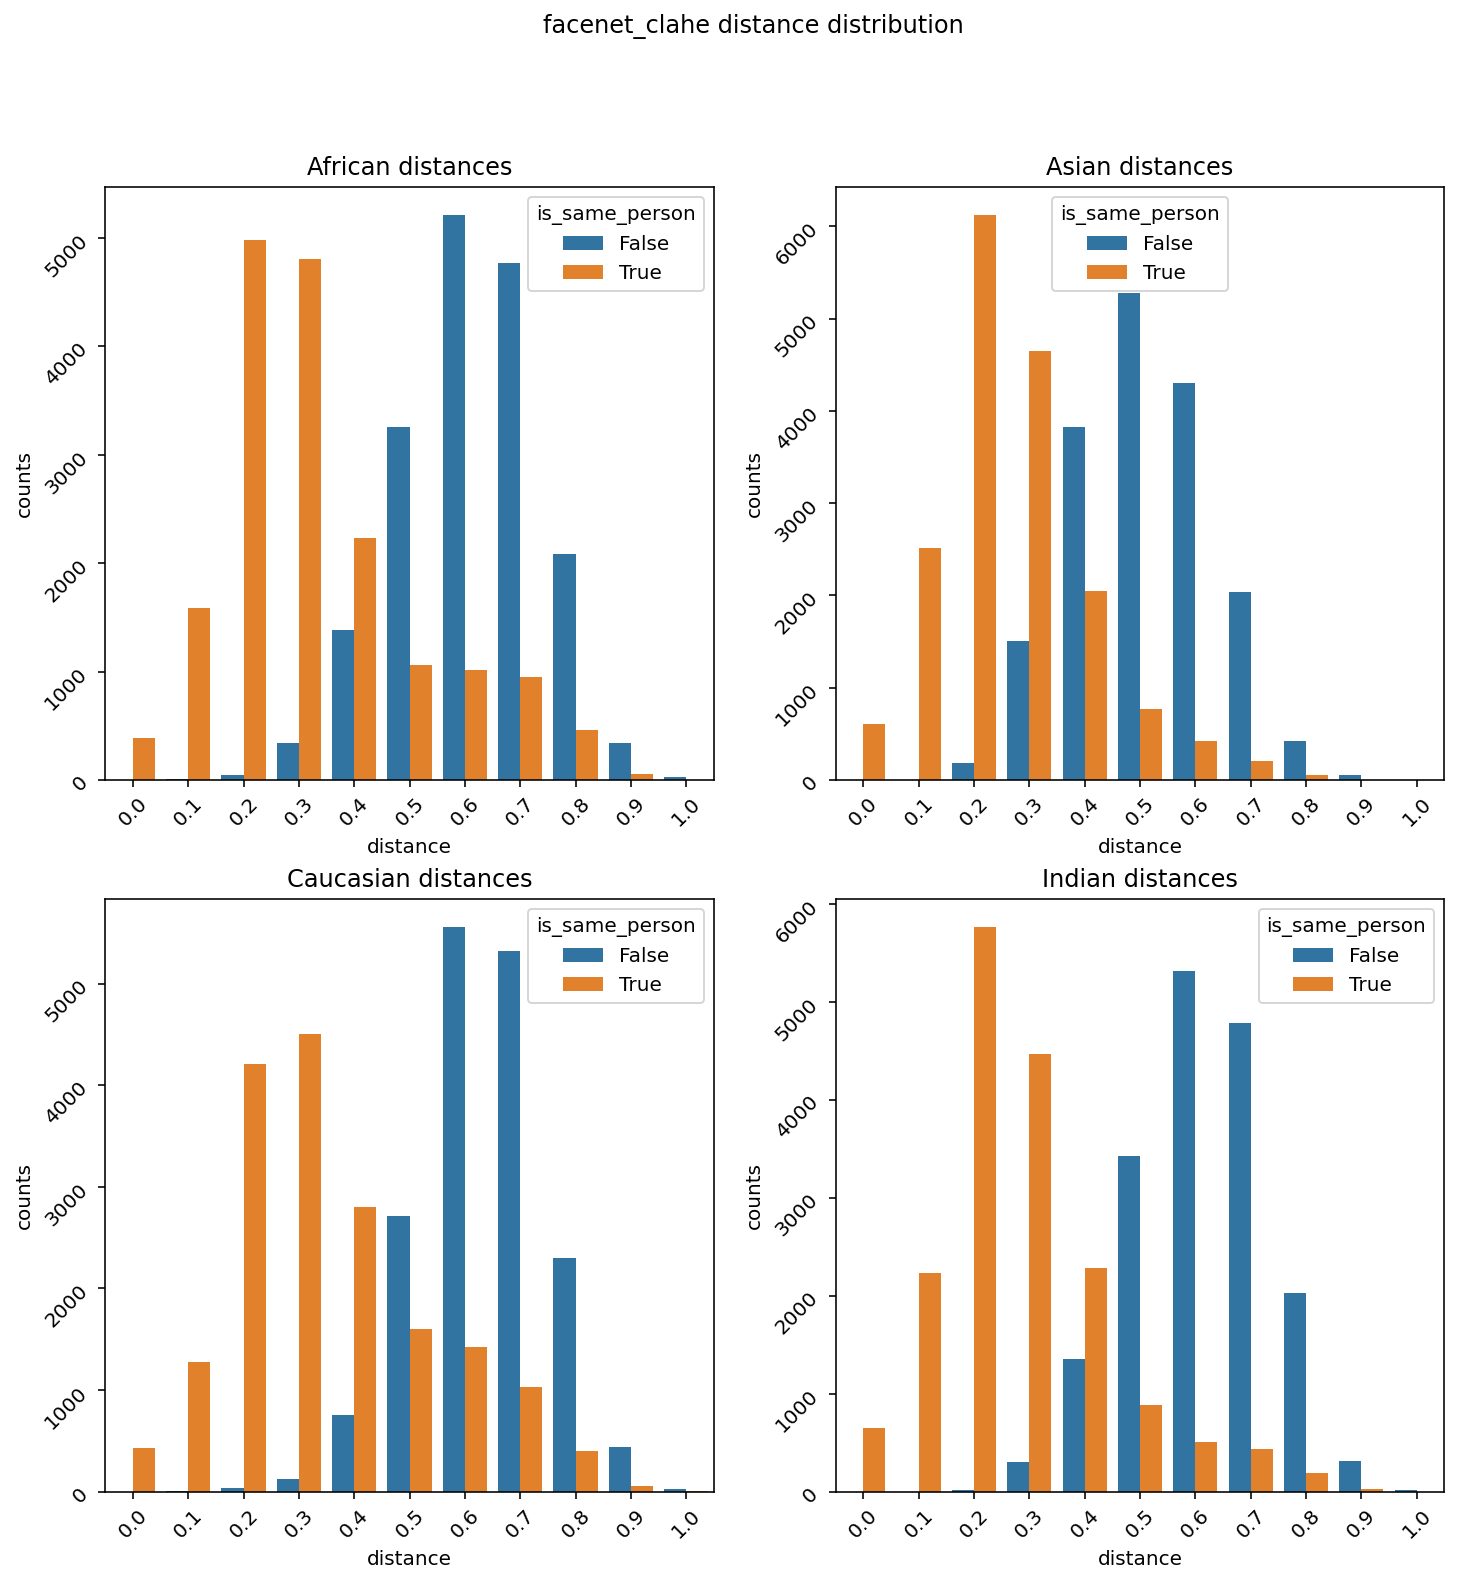

In [18]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [18]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.34599559594849677
African difference in mean: -0.4326776962302334
Caucasian difference in mean: -0.4174489681861643
Indian difference in mean: -0.45363286343413517


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


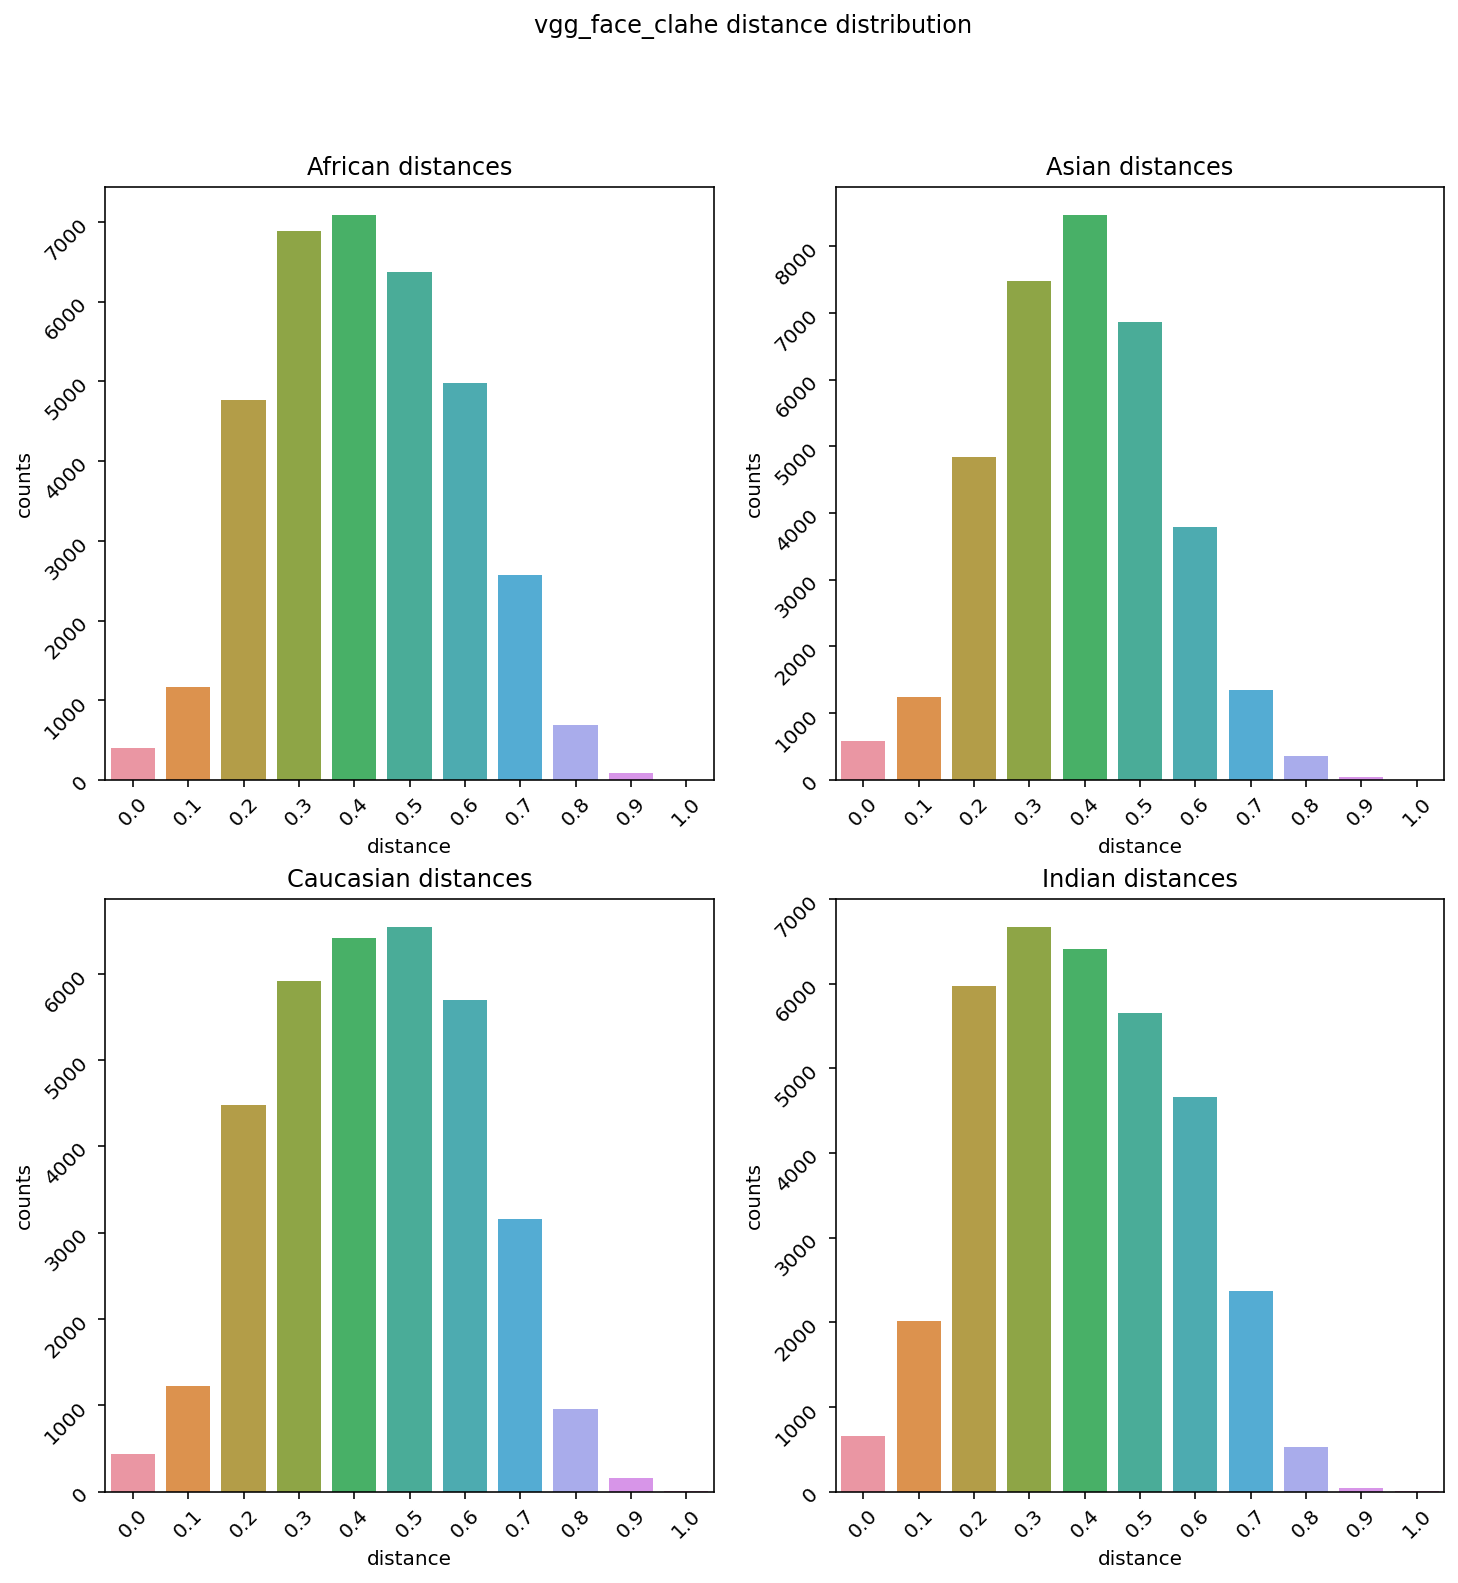

In [20]:
plot_score_distribution(vgg_face_model)

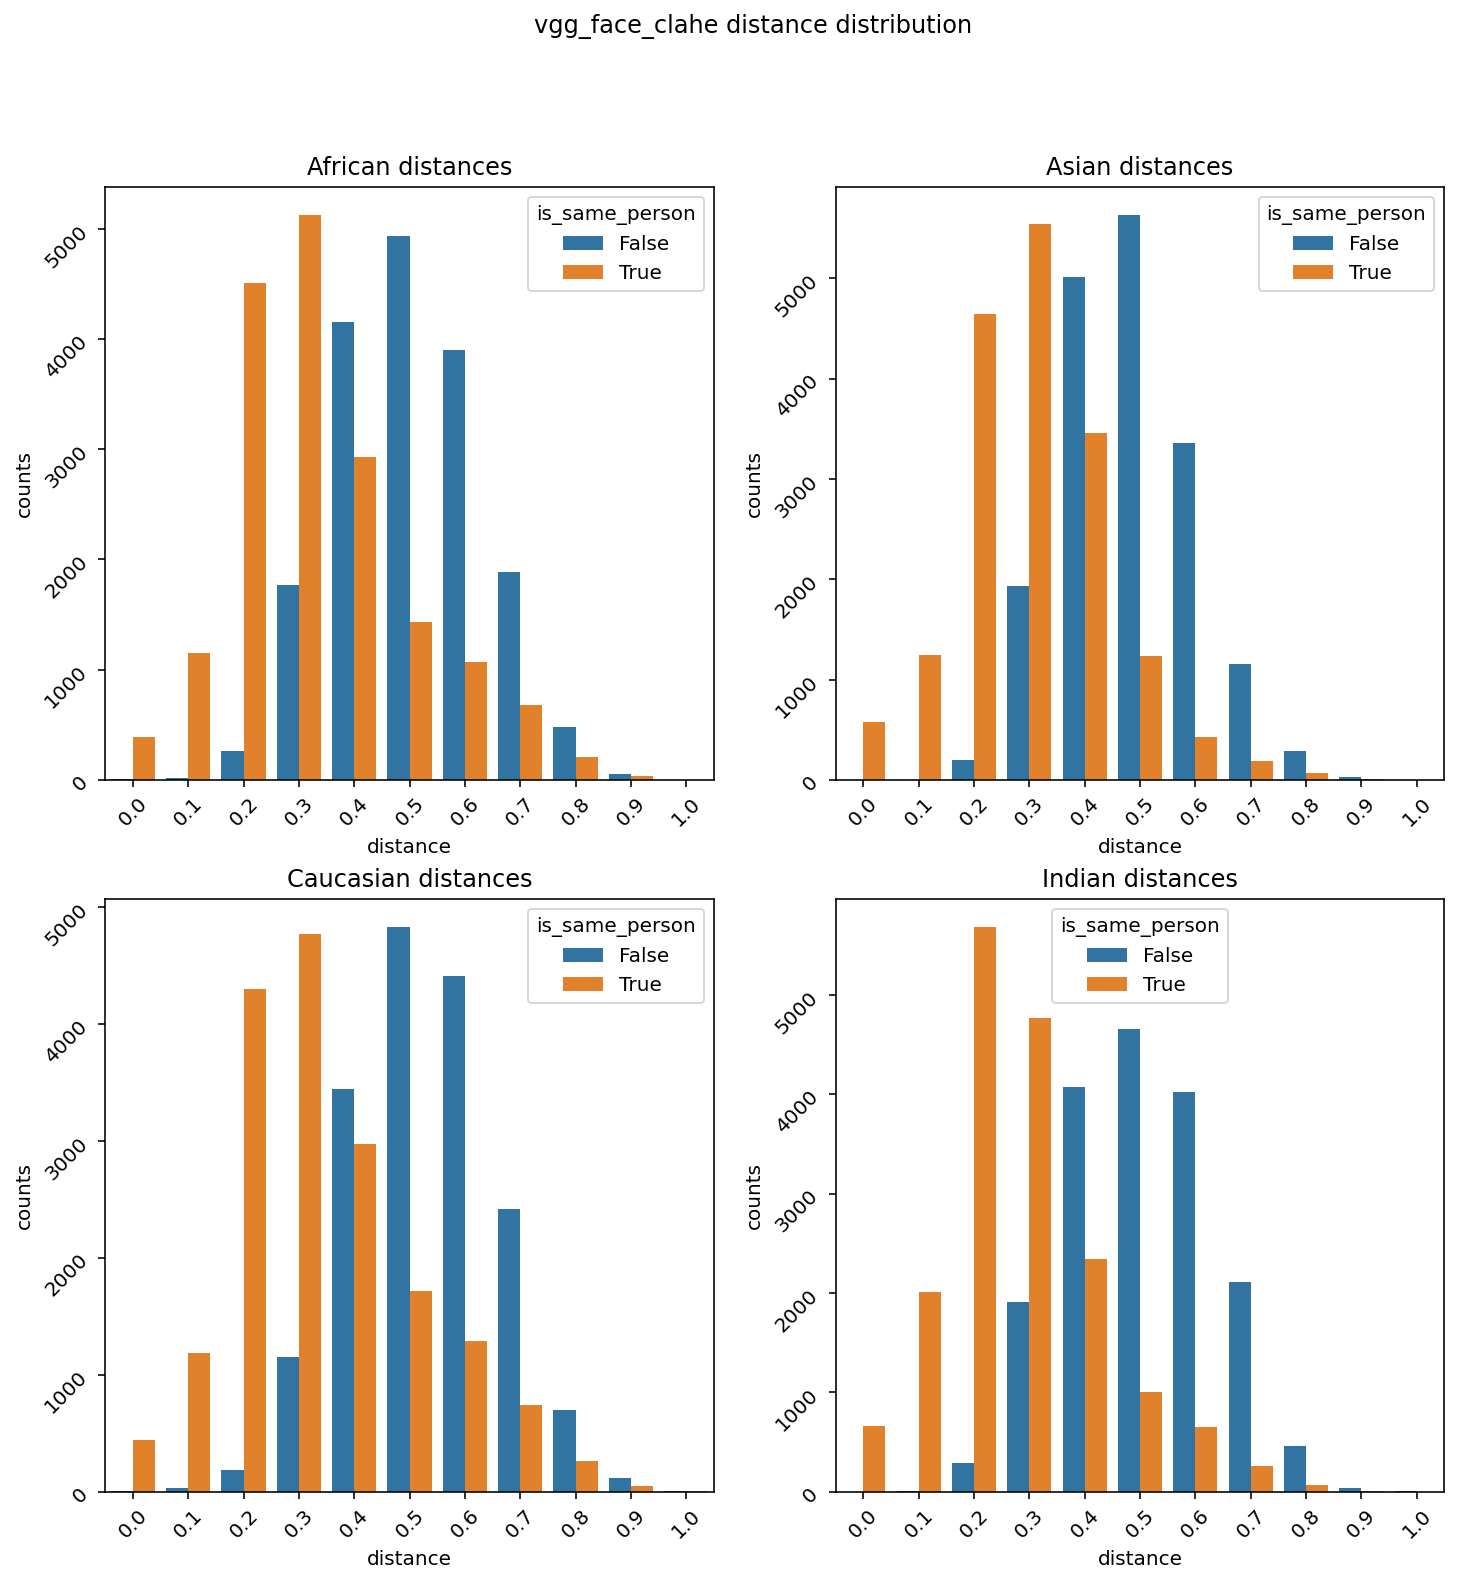

In [21]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [22]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.18225465522831313
African difference in mean: -0.1848424186524324
Caucasian difference in mean: -0.20033682119371427
Indian difference in mean: -0.2349264218594605


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

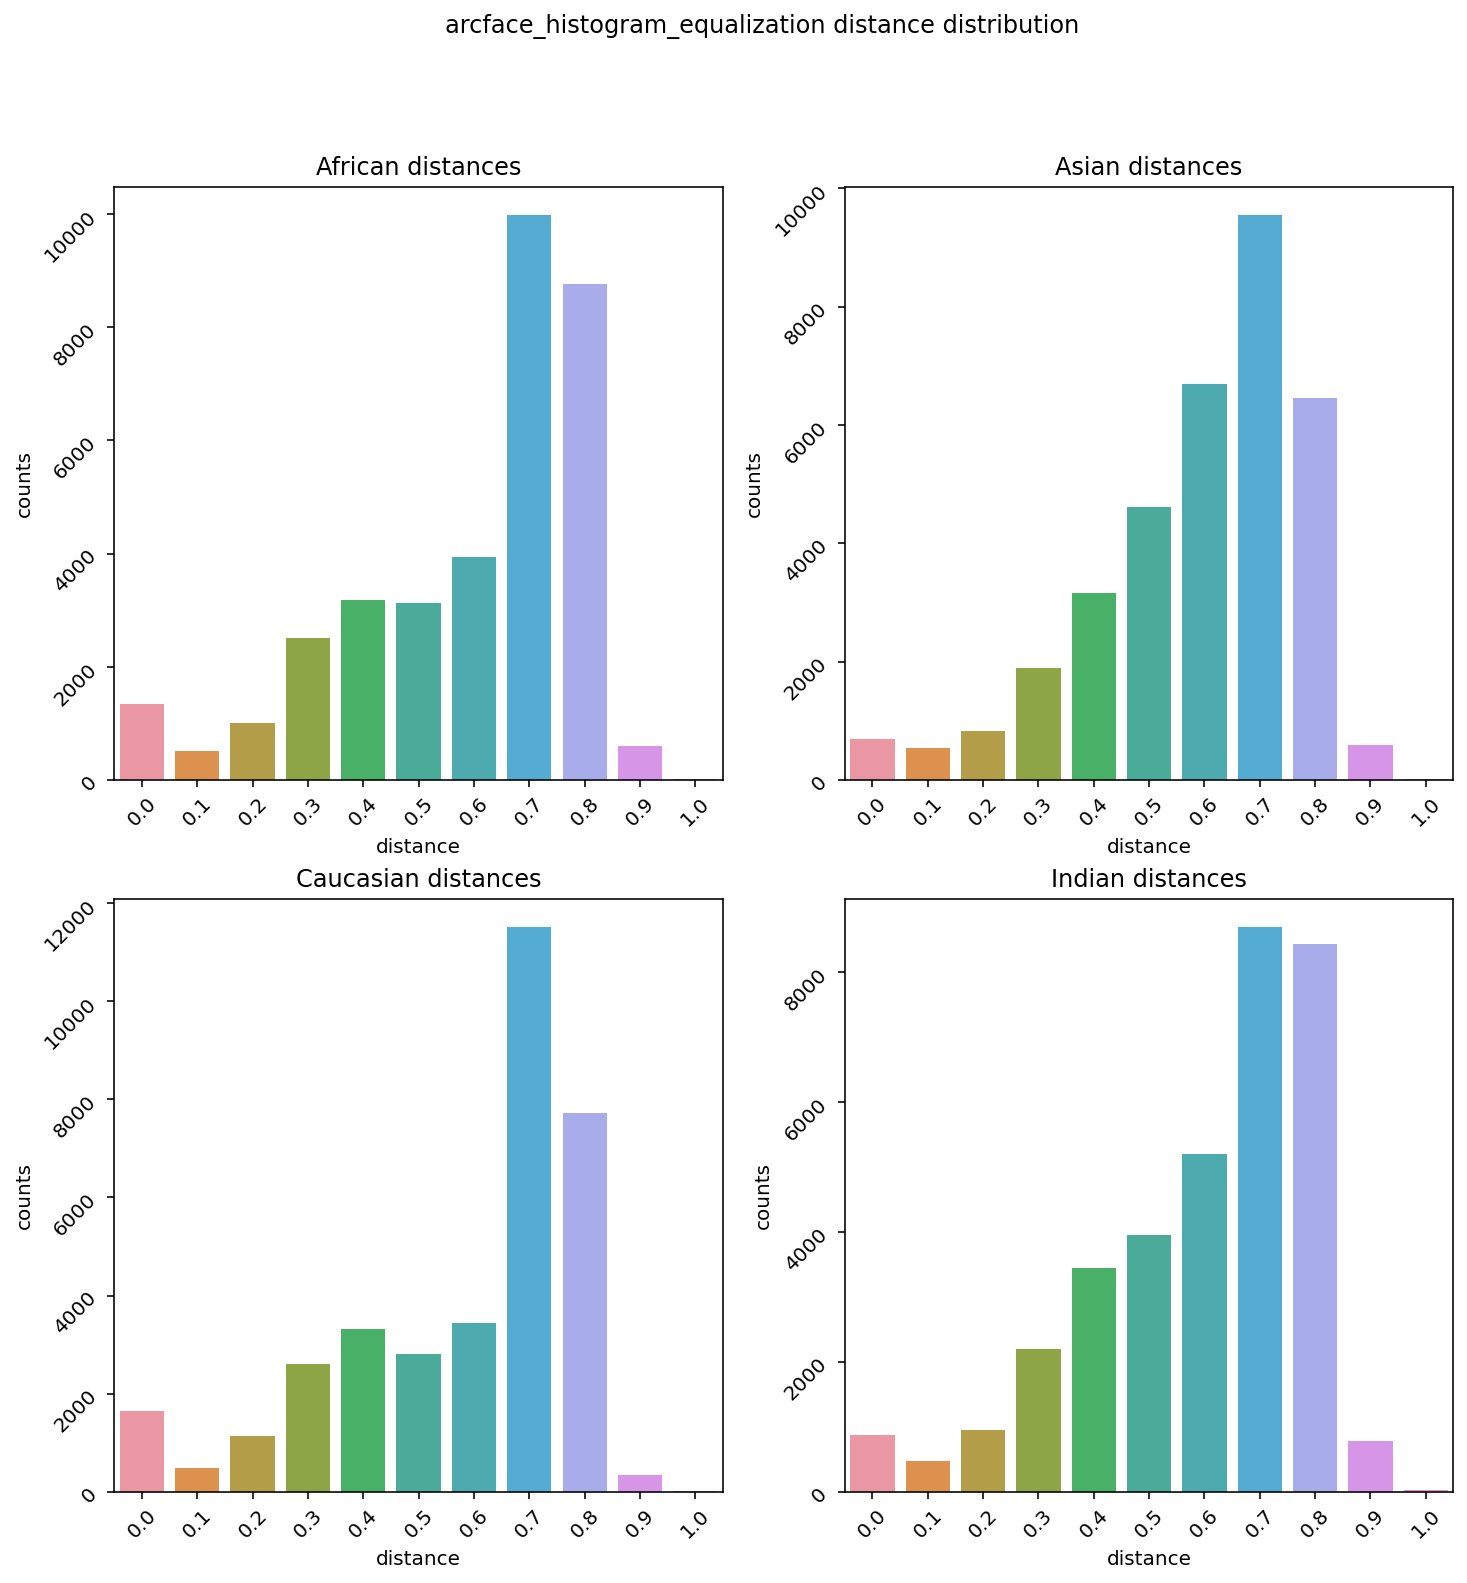

In [23]:
plot_score_distribution(arcface_model)

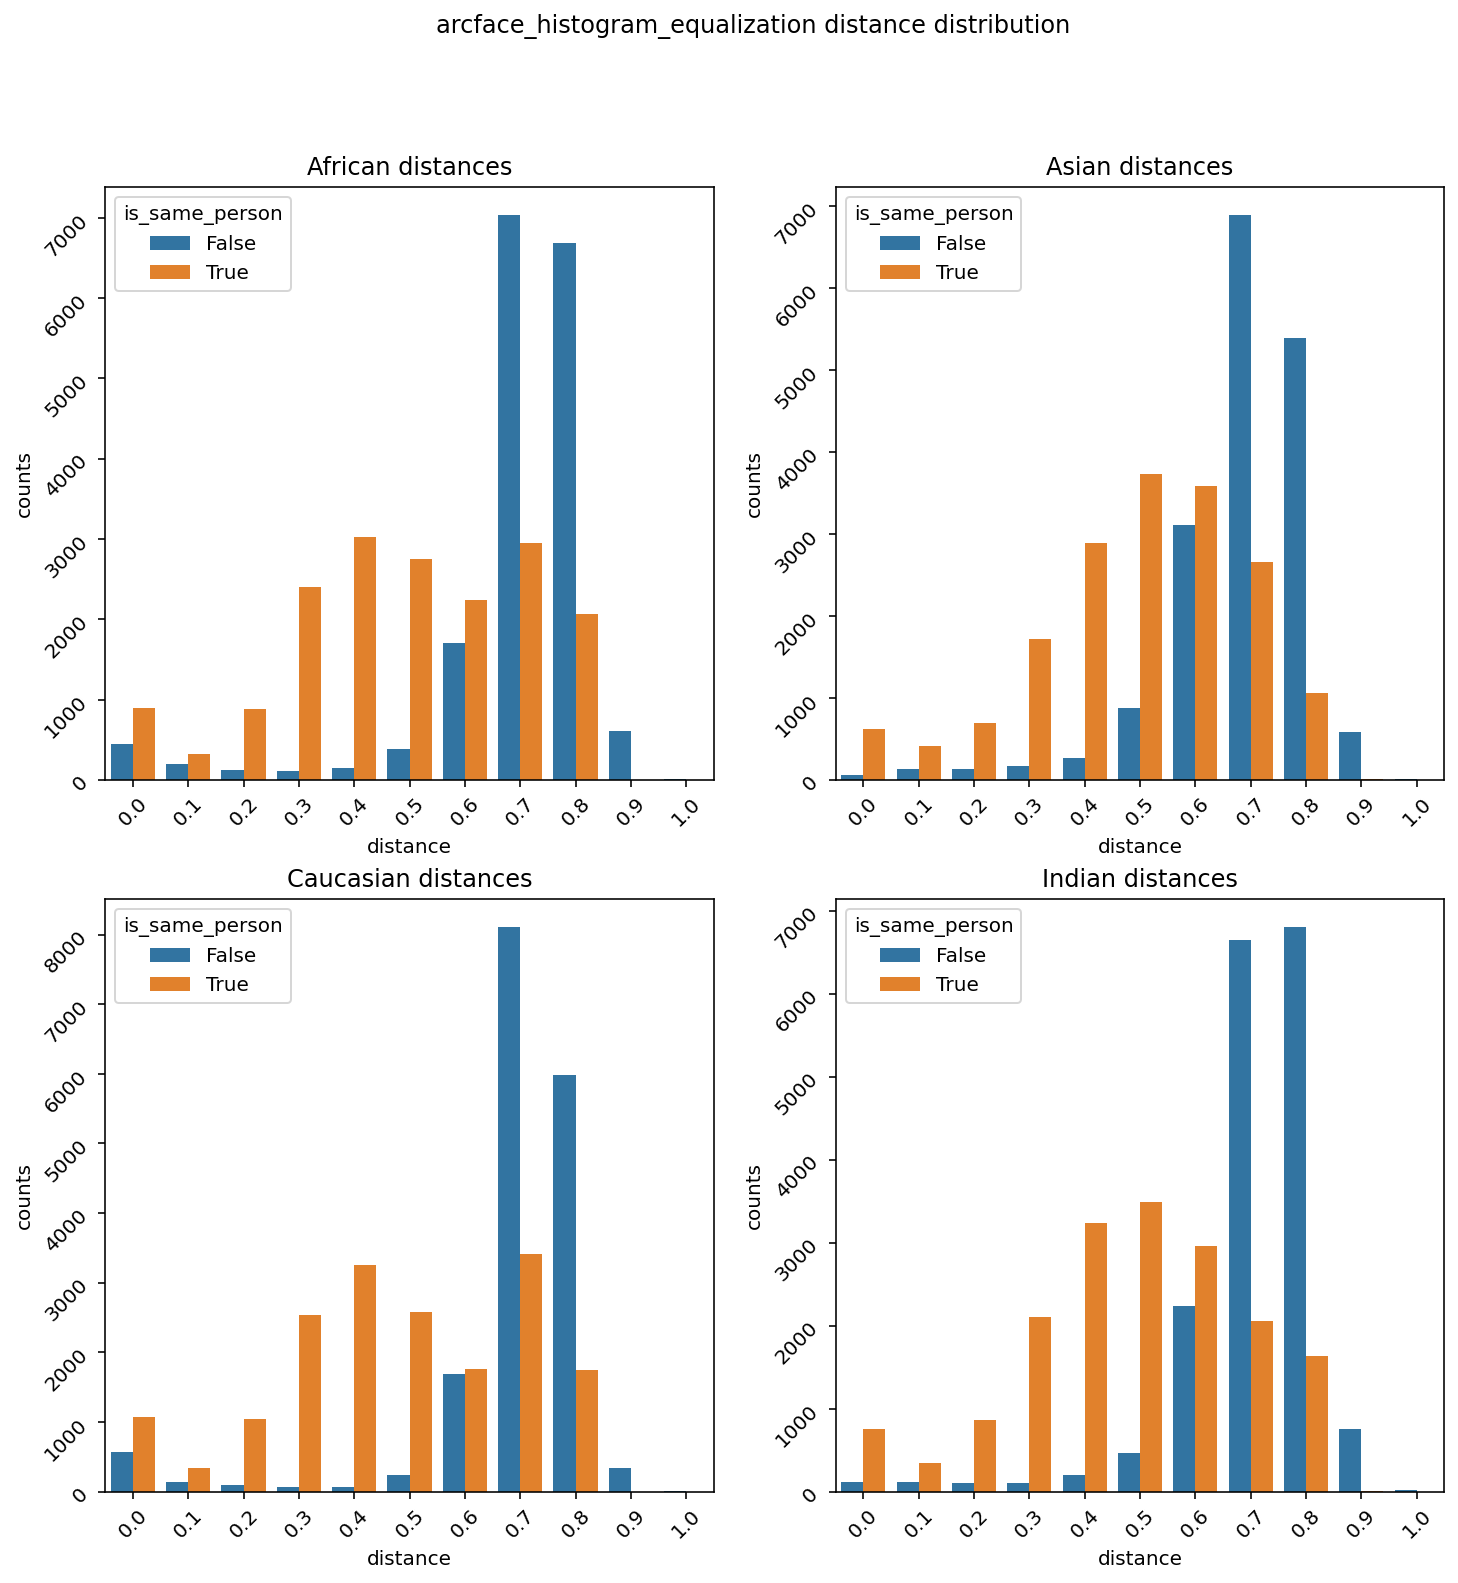

In [24]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [25]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.2451471186609162
African difference in mean: -0.26751077204090823
Caucasian difference in mean: -0.2840452904788233
Indian difference in mean: -0.28577164212023354


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [26]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [27]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [28]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 1.1416837892585461e-34
Wilcoxon test on Asian performance: 6.757978247442735e-27
Wilcoxon test on African performance: 0.9176068968177927
Wilcoxon test on Indian performance: 1.6194864626223344e-07


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [29]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.669095022981974e-88
Wilcoxon test on Asian performance:  2.4899514434366993e-11
Wilcoxon test on African performance:  8.250067449613307e-09
Wilcoxon test on Indian performance:  2.9291149337216237e-21


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [30]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  0.015121480296842299
Wilcoxon test on Asian performance:  3.135466652924243e-15
Wilcoxon test on African performance:  0.00015980594313004046
Wilcoxon test on Indian performance:  2.0852601936304208e-11


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [32]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [61]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = bilateral_denoising)

In [62]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.3677601885258135
Prediction_local [2.47537734]
Right: 2.8296676
Intercept -0.9373930269420199
Prediction_local [2.57125049]
Right: 3.0180702


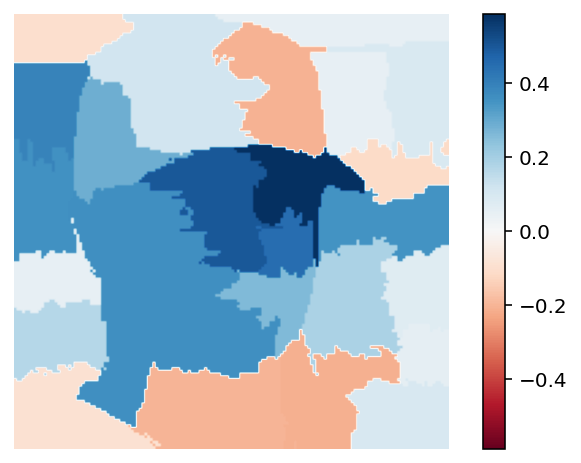

In [63]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.1560417036814845
Prediction_local [2.49821897]
Right: 2.8666465
Intercept -2.4887696632644194
Prediction_local [2.21909711]
Right: 3.2322078


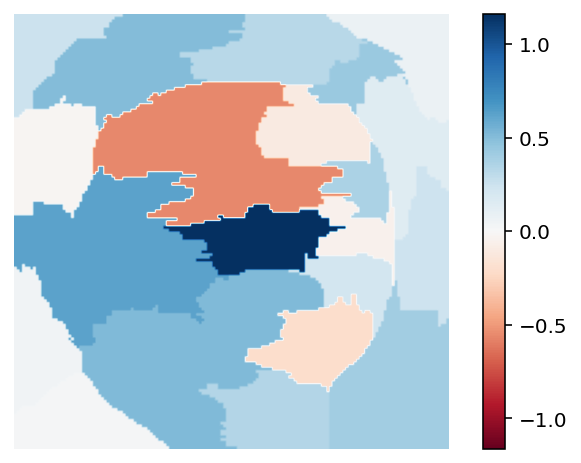

In [64]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -3.2396850944279647
Prediction_local [2.1333047]
Right: 3.0249827
Intercept -1.7334206923965065
Prediction_local [2.56120931]
Right: 3.5215511


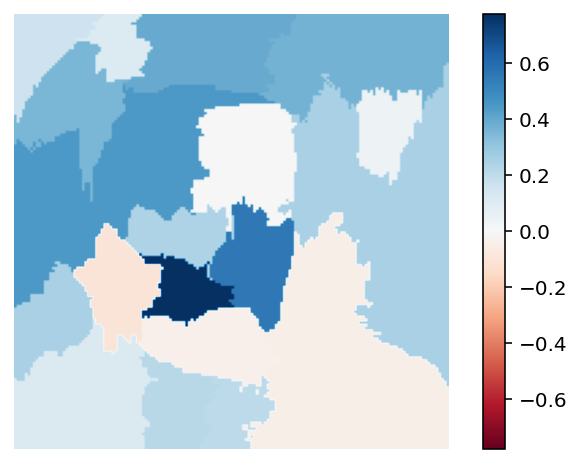

In [65]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.3781669174589184
Prediction_local [1.91818814]
Right: 2.319225
Intercept -0.5640004359763866
Prediction_local [1.86639009]
Right: 2.3580284


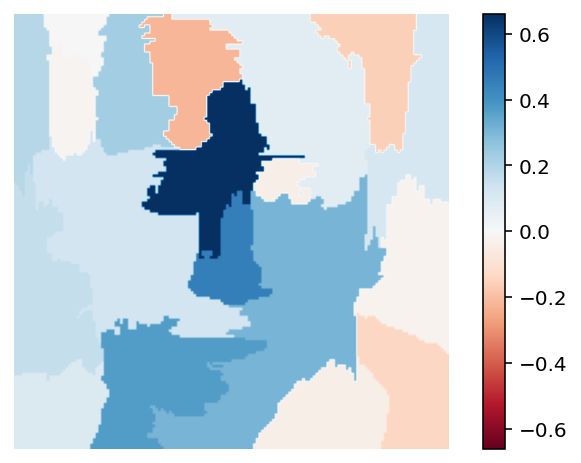

In [66]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [67]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = bilateral_denoising)

In [68]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.025121676100380404
Prediction_local [0.05823666]
Right: 0.058556315
Intercept -0.04383620694266053
Prediction_local [0.05812845]
Right: 0.061647017


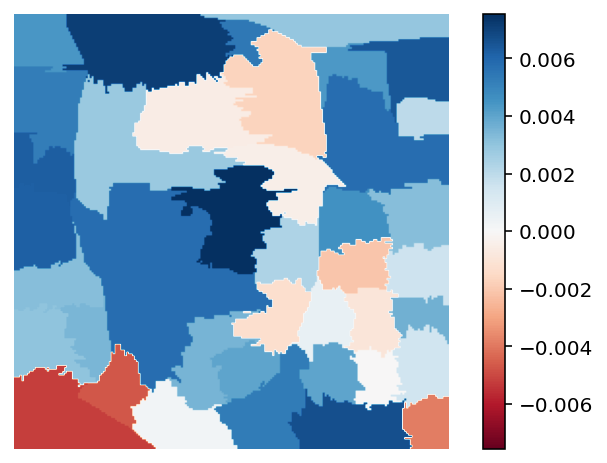

In [69]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.02615502521686866
Prediction_local [0.060484]
Right: 0.058556315
Intercept -0.03942804152327882
Prediction_local [0.06039845]
Right: 0.061647017


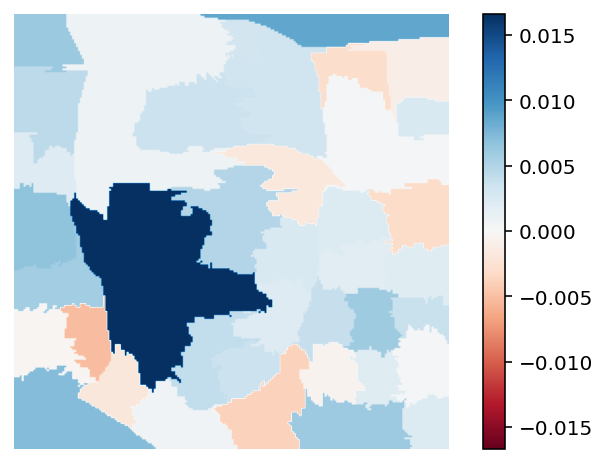

In [70]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.012520198145398773
Prediction_local [0.05786847]
Right: 0.06538818
Intercept 0.10330850625564814
Prediction_local [0.07155357]
Right: 0.066208355


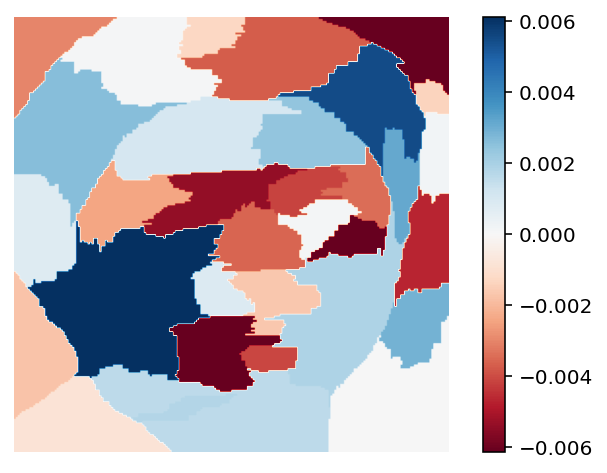

In [71]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.09076876653642867
Prediction_local [0.09505872]
Right: 0.109682456
Intercept -0.07837862881952715
Prediction_local [0.09533546]
Right: 0.11153754


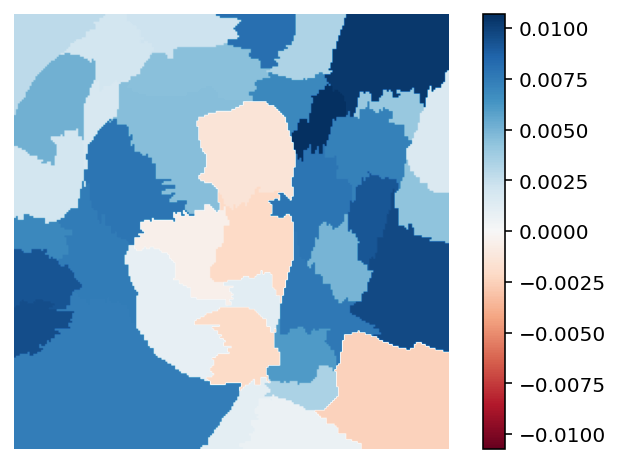

In [72]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.05330425851368058
Prediction_local [0.03663661]
Right: 0.037373807
Intercept -0.044625350793053534
Prediction_local [0.03390359]
Right: 0.045499053


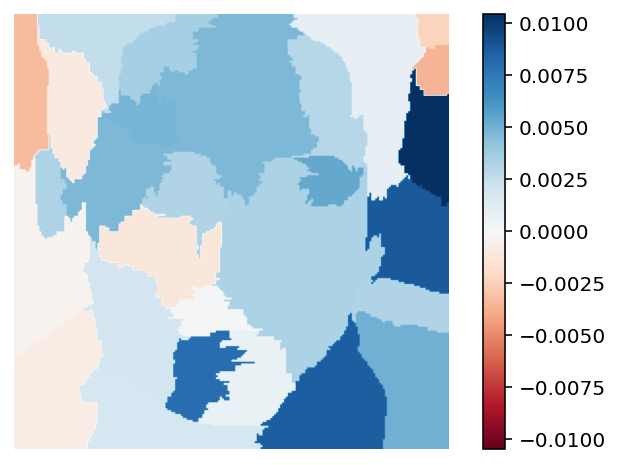

In [73]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [74]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = bilateral_denoising)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = bilateral_denoising)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = bilateral_denoising)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = bilateral_denoising)

In [75]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 0.6180366108724308
Prediction_local [0.59974071]
Right: 0.27538815
Intercept 10.641198539338694
Prediction_local [2.22562433]
Right: 0.38241002


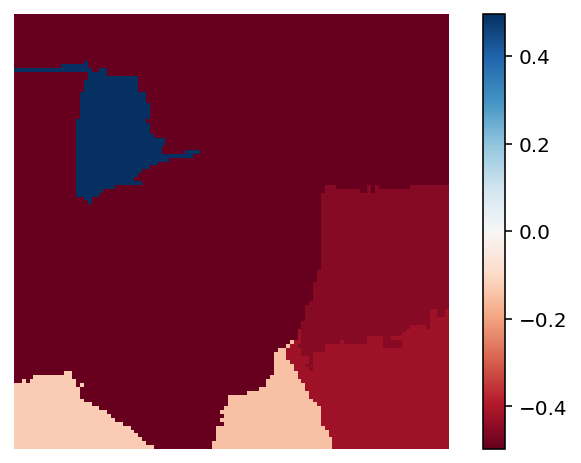

In [76]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 9.112572830497307
Prediction_local [0.95498165]
Right: 0.40566242
Intercept -3.8132981431114823
Prediction_local [1.33125802]
Right: 0.514159


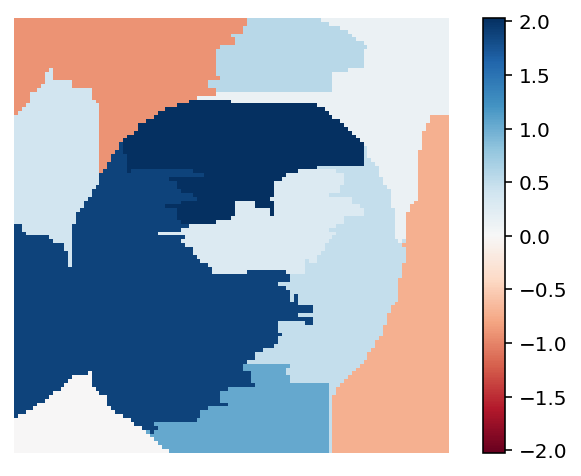

In [77]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -1.3327380144385859
Prediction_local [2.56940373]
Right: 0.3993446
Intercept -1.7524215671378038
Prediction_local [1.33586047]
Right: 0.3996247


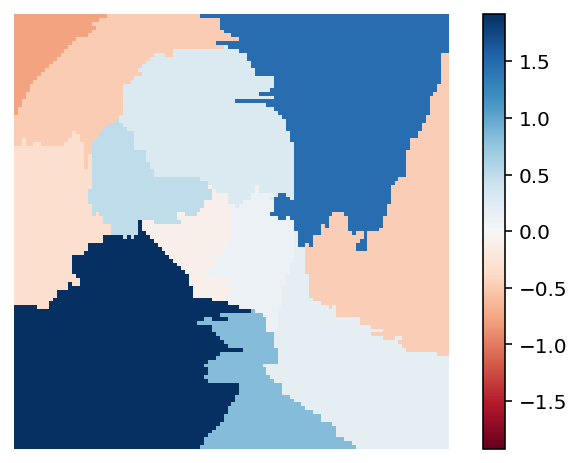

In [78]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 3.3503526901658747
Prediction_local [-0.2702257]
Right: 0.42672178
Intercept 5.282178830908144
Prediction_local [1.25537542]
Right: 0.5497708


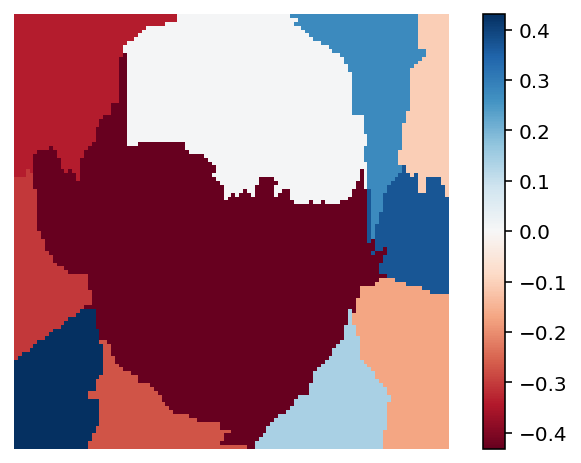

In [79]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others